[paper](https://www.nature.com/articles/s41746-020-00372-6.pdf)  
[dataset](https://github.com/nshomron/covidpred)

## 1. Data Preprocessing

In [91]:
# 安裝會使用到的套件
%pip install sklearn seaborn

Note: you may need to restart the kernel to use updated packages.


In [92]:
# 確認當前工作目錄
%pwd

'c:\\Users\\betty\\D\\資管所\\Data_Mining\\project\\mid'

In [93]:
import pandas as pd
import re
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn import feature_extraction, model_selection, naive_bayes,pipeline,\
manifold, preprocessing, feature_selection, metrics, svm, tree, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix


import seaborn as sns
import time

In [94]:
metadata = pd.read_csv("covid.csv") #匯資料
metadata.head(3)

C:\Users\betty\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0,0,0,0,0,negative,None,female,Other
1,2020-04-30,1,0,0,0,0,negative,None,female,Other
2,2020-04-30,0,1,0,0,0,negative,None,male,Other


In [95]:
# 增加id
metadata=metadata.assign(cov_id=metadata.index)

In [96]:
# 共有 278848 筆資料
metadata.shape

(278848, 11)

### 1.1. 方法一 : 去除空值

In [97]:
metadata['cough']=metadata['cough'].replace('None',np.nan)
metadata['fever']=metadata['fever'].replace('None',np.nan)
metadata['sore_throat']=metadata['sore_throat'].replace('None',np.nan)
metadata['shortness_of_breath']=metadata['shortness_of_breath'].replace('None',np.nan)
metadata['head_ache']=metadata['head_ache'].replace('None',np.nan)
metadata['gender']=metadata['gender'].replace(['female', 'male', 'None'], [0,1,np.nan])
metadata['age_60_and_above']=metadata['age_60_and_above'].replace(['None', 'No', 'Yes'], [np.nan, 0 ,1])
# metadata['gender']=metadata['gender'].replace(['female', 'male'], [0,1])
# metadata['age_60_and_above']=metadata['age_60_and_above'].replace(['No', 'Yes'], [0 ,1])
metadata

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,cov_id
0,2020-04-30,0,0,0,0,0,negative,NaN,0.0,Other,0
1,2020-04-30,1,0,0,0,0,negative,NaN,0.0,Other,1
2,2020-04-30,0,1,0,0,0,negative,NaN,1.0,Other,2
3,2020-04-30,1,0,0,0,0,negative,NaN,0.0,Other,3
4,2020-04-30,1,0,0,0,0,negative,NaN,1.0,Other,4
...,...,...,...,...,...,...,...,...,...,...,...
278843,2020-03-11,0,0,0,0,0,negative,NaN,NaN,Other,278843
278844,2020-03-11,0,0,0,0,0,negative,NaN,NaN,Other,278844
278845,2020-03-11,0,0,0,0,0,positive,NaN,NaN,Contact with confirmed,278845
278846,2020-03-11,0,0,0,0,0,other,NaN,NaN,Other,278846


In [98]:
drop_na=metadata.dropna()
print(drop_na)
drop_na[drop_na['gender']=='None']

         test_date cough fever sore_throat shortness_of_breath head_ache  \
122808  2020-04-14     1     0           0                   0         0   
122809  2020-04-14     1     0           0                   0         0   
122810  2020-04-14     0     0           0                   0         0   
122811  2020-04-14     0     1           0                   0         0   
122812  2020-04-14     1     0           0                   0         0   
...            ...   ...   ...         ...                 ...       ...   
265116  2020-03-22     1     1           0                   0         0   
265117  2020-03-22     1     1           1                   0         1   
265118  2020-03-22     1     0           0                   0         0   
265119  2020-03-22     1     0           0                   0         0   
265120  2020-03-22     1     0           0                   0         0   

       corona_result  age_60_and_above  gender test_indication  cov_id  
122808      ne

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,cov_id


## 2. 將資料分為測試集和訓練集


### 2.1. 根據7:3的比例切分資料集 

利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。

#### 2.1.1 all features

In [125]:
y= drop_na.corona_result

features_all=['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender']
X_all =drop_na[features_all]

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.3, random_state=2022)

#### 2.1.2 filtered features

In [171]:
y= drop_na.corona_result

features_filter=['cough', 'fever', 'age_60_and_above', 'gender']
X_filter =drop_na[features_filter]

X_train_filter, X_test_filter, y_train_filter, y_test_filter = train_test_split(X_filter, y, test_size=0.3, random_state=2022)

In [172]:
print(f"raw data percentage :\n{metadata['corona_result'].value_counts(normalize=True) * 100}")

raw data percentage :
negative    93.322168
positive     5.282089
other        1.395742
Name: corona_result, dtype: float64


In [173]:
result_df = pd.DataFrame(columns=['model_type', 'Accuracy', 'AUC'])
roc_auc_all = {}

### 2.2. Logistic Regression

In [174]:
model_type="Logistic Regression (all)"
lr_all = LogisticRegression()
lr_all.fit(X_train_all, y_train_all)

LogisticRegression()

In [175]:
predicted_all = lr_all.predict(X_test_all)
predicted_prob_all = lr_all.predict_proba(X_test_all)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

Accuracy: 0.93
Auc: 0.7
Detail:


C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.93      1.00      0.96     37678
       other       0.00      0.00      0.00       576
    positive       0.92      0.31      0.47      3198

    accuracy                           0.93     41452
   macro avg       0.62      0.44      0.48     41452
weighted avg       0.92      0.93      0.91     41452



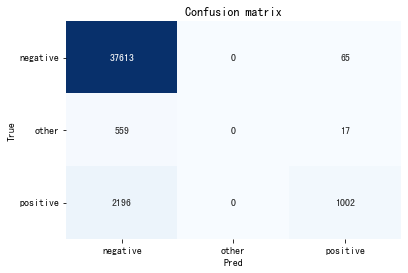

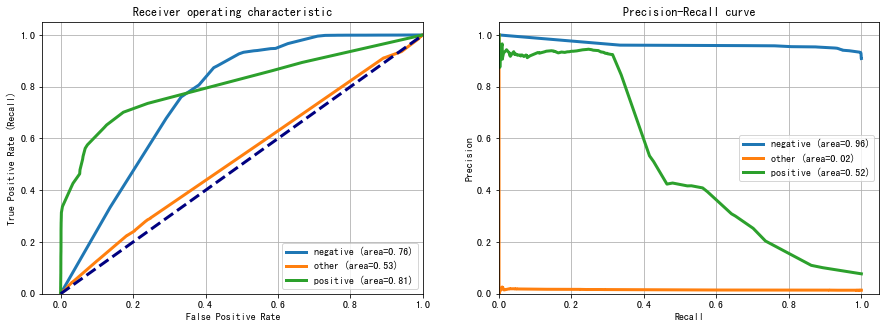

In [176]:
classes = np.unique(y_test_all)
y_test_array = pd.get_dummies(y_test_all, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_all, predicted_all)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_all, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_all, predicted_all))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_all, predicted_all)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_all[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_all[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

In [177]:
model_type="Logistic Regression (filtered)"
lr_filter = LogisticRegression()
lr_filter.fit(X_train_filter, y_train_filter)

LogisticRegression()

In [178]:
predicted_filter = lr_filter.predict(X_test_filter)
predicted_prob_filter = lr_filter.predict_proba(X_test_filter)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

Accuracy: 0.91
Auc: 0.66
Detail:


C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.91      1.00      0.95     37678
       other       0.00      0.00      0.00       576
    positive       0.00      0.00      0.00      3198

    accuracy                           0.91     41452
   macro avg       0.30      0.33      0.32     41452
weighted avg       0.83      0.91      0.87     41452



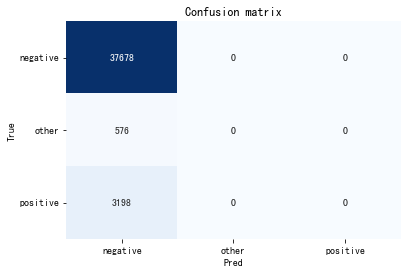

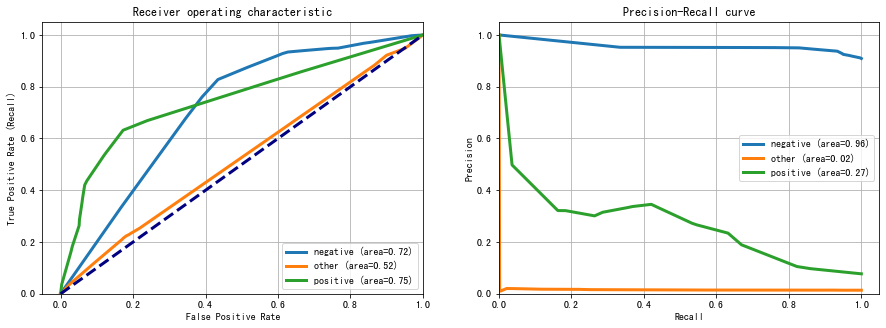

In [179]:
classes = np.unique(y_test_filter)
y_test_array = pd.get_dummies(y_test_filter, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_filter, predicted_filter)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_filter, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_filter, predicted_filter))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_filter, predicted_filter)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_filter[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_filter[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 2.3. Decision Tree

In [180]:
dt_all = DecisionTreeClassifier()
dt_all.fit(X_train_all, y_train_all)

DecisionTreeClassifier()

In [181]:
model_type="Decision Tree (all)"
predicted_all = dt_all.predict(X_test_all)
predicted_prob_all = dt_all.predict_proba(X_test_all)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

[Text(7421.946022727273, 2548.125, 'head_ache <= 0.5\ngini = 0.166\nsamples = 96720\nvalue = [87990, 1302, 7428]\nclass = negative'),
 Text(3879.403409090909, 2208.375, 'fever <= 0.5\ngini = 0.144\nsamples = 95263\nvalue = [87928, 1287, 6048]\nclass = negative'),
 Text(2034.375, 1868.625, 'sore_throat <= 0.5\ngini = 0.107\nsamples = 87108\nvalue = [82231, 1166, 3711]\nclass = negative'),
 Text(1127.2727272727273, 1528.875, 'shortness_of_breath <= 0.5\ngini = 0.101\nsamples = 86790\nvalue = [82198, 1164, 3428]\nclass = negative'),
 Text(563.6363636363636, 1189.125, 'cough <= 0.5\ngini = 0.098\nsamples = 86575\nvalue = [82170, 1163, 3242]\nclass = negative'),
 Text(281.8181818181818, 849.375, 'gender <= 0.5\ngini = 0.083\nsamples = 76023\nvalue = [72769, 1050, 2204]\nclass = negative'),
 Text(140.9090909090909, 509.625, 'age_60_and_above <= 0.5\ngini = 0.078\nsamples = 37832\nvalue = [36314, 528, 990]\nclass = negative'),
 Text(70.45454545454545, 169.875, 'gini = 0.074\nsamples = 30389\n

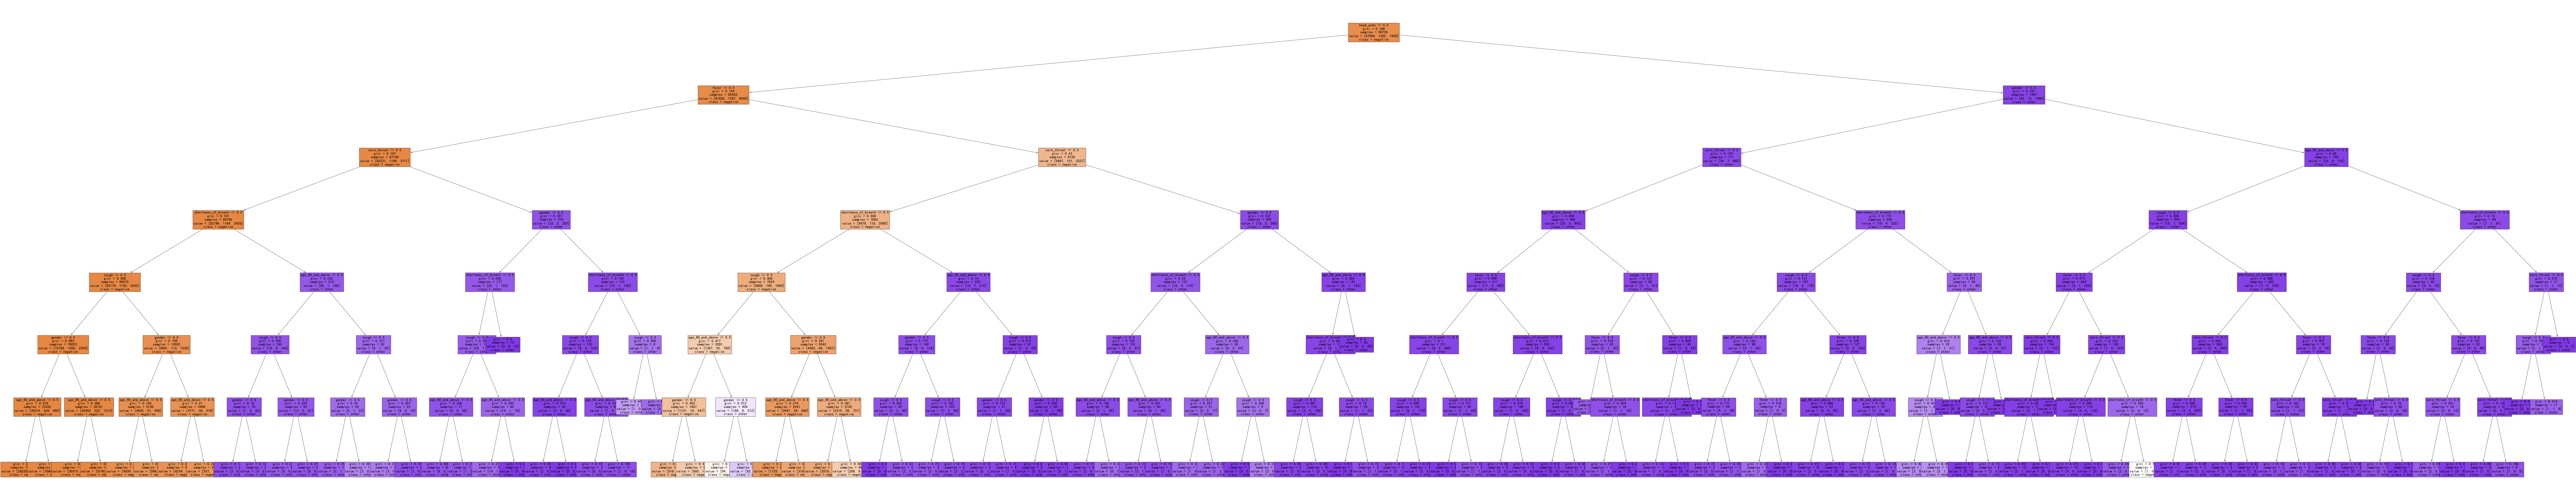

In [182]:
class_name=['negative', 'positive', 'other']
fig=plt.figure(figsize=(250, 50))
plot_tree(dt_all, 
          feature_names=features_all,
          class_names=class_name,
          fontsize=20,
          filled=True)

Accuracy: 0.93
Auc: 0.69
Detail:


C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.93      1.00      0.96     37678
       other       0.00      0.00      0.00       576
    positive       0.90      0.33      0.48      3198

    accuracy                           0.93     41452
   macro avg       0.61      0.44      0.48     41452
weighted avg       0.92      0.93      0.91     41452



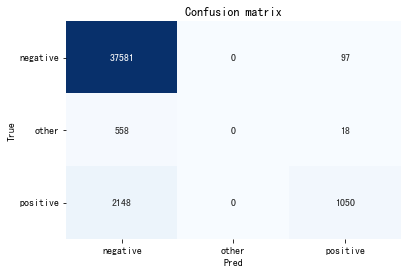

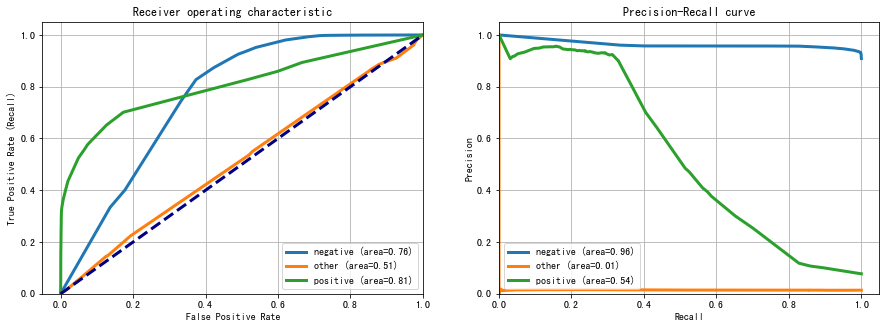

In [183]:
classes = np.unique(y_test_all)
y_test_array = pd.get_dummies(y_test_all, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_all, predicted_all)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_all, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_all, predicted_all))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_all, predicted_all)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_all[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
            label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_all[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

In [184]:
dt_filter = DecisionTreeClassifier()
dt_filter.fit(X_train_filter, y_train_filter)

DecisionTreeClassifier()

In [185]:
model_type="Decision Tree (filterd)"
predicted_filter = dt_filter.predict(X_test_filter)
predicted_prob_filter = dt_filter.predict_proba(X_test_filter)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

[Text(6975.0, 2446.2, 'fever <= 0.5\ngini = 0.166\nsamples = 96720\nvalue = [87990, 1302, 7428]\nclass = negative'),
 Text(3487.5, 1902.6, 'cough <= 0.5\ngini = 0.119\nsamples = 87757\nvalue = [82261, 1173, 4323]\nclass = negative'),
 Text(1743.75, 1359.0, 'gender <= 0.5\ngini = 0.094\nsamples = 76571\nvalue = [72807, 1053, 2711]\nclass = negative'),
 Text(871.875, 815.3999999999999, 'age_60_and_above <= 0.5\ngini = 0.09\nsamples = 38131\nvalue = [36340, 530, 1261]\nclass = negative'),
 Text(435.9375, 271.7999999999997, 'gini = 0.088\nsamples = 30650\nvalue = [29249, 402, 999]\nclass = negative'),
 Text(1307.8125, 271.7999999999997, 'gini = 0.1\nsamples = 7481\nvalue = [7091, 128, 262]\nclass = negative'),
 Text(2615.625, 815.3999999999999, 'age_60_and_above <= 0.5\ngini = 0.098\nsamples = 38440\nvalue = [36467, 523, 1450]\nclass = negative'),
 Text(2179.6875, 271.7999999999997, 'gini = 0.1\nsamples = 31985\nvalue = [30324, 433, 1228]\nclass = negative'),
 Text(3051.5625, 271.799999999

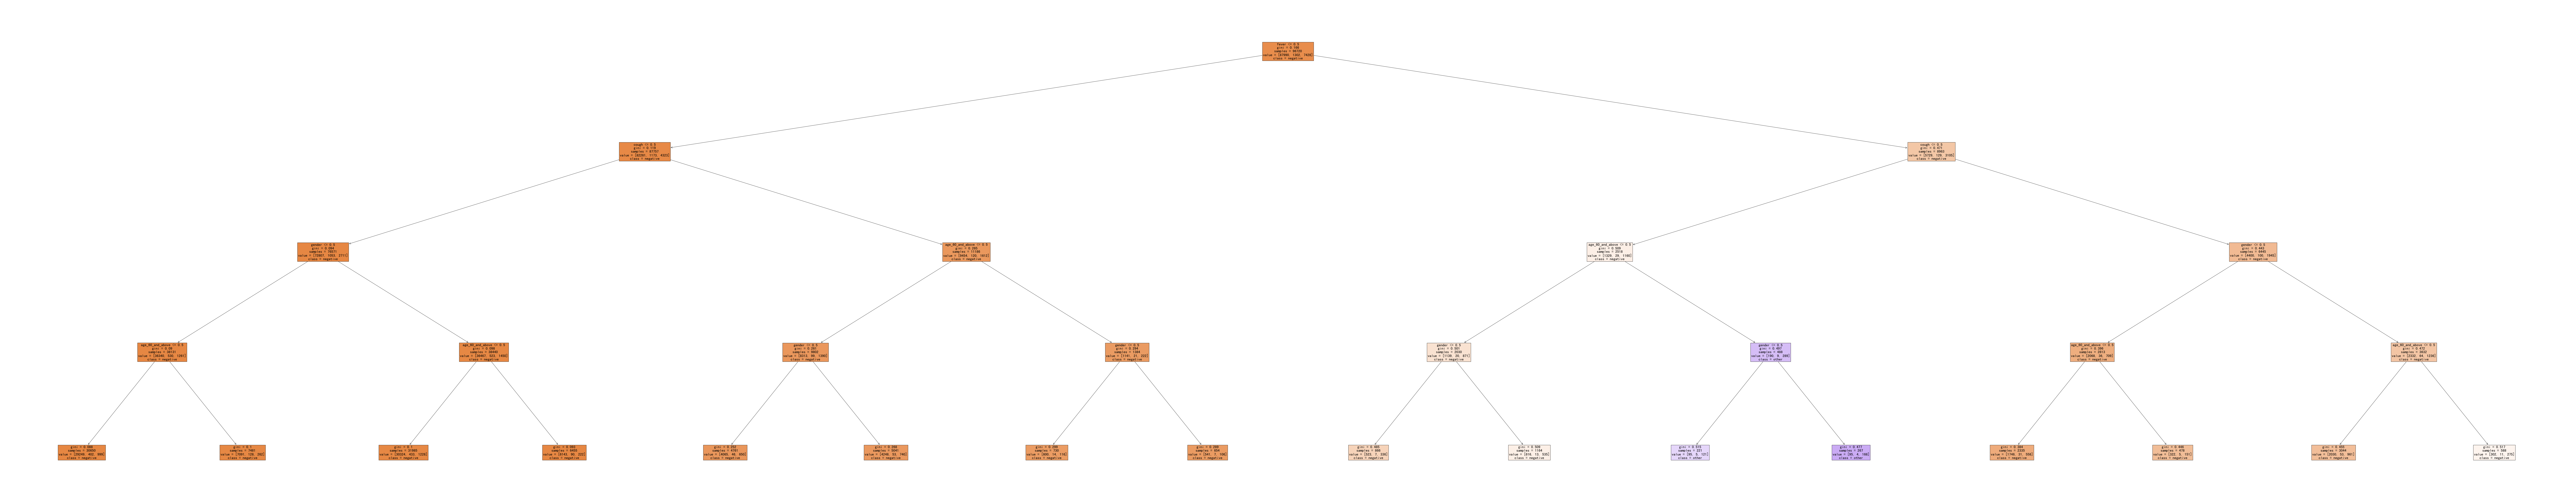

In [186]:
class_name=['negative', 'positive', 'other']
fig=plt.figure(figsize=(250, 50))
plot_tree(dt_filter, 
          feature_names=features_filter,
          class_names=class_name,
          fontsize=20,
          filled=True)

Accuracy: 0.91
Auc: 0.66
Detail:


C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.91      1.00      0.95     37678
       other       0.00      0.00      0.00       576
    positive       0.59      0.04      0.07      3198

    accuracy                           0.91     41452
   macro avg       0.50      0.34      0.34     41452
weighted avg       0.87      0.91      0.87     41452



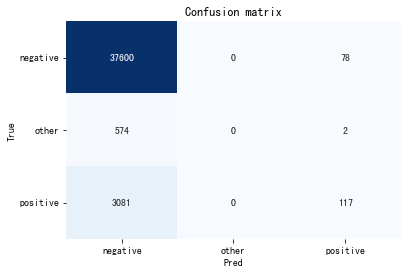

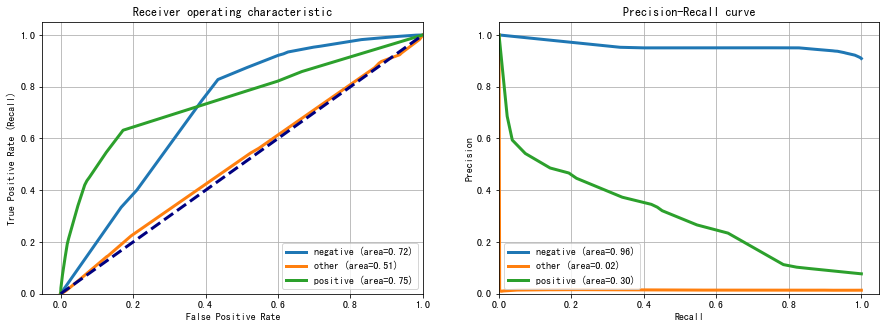

In [187]:
classes = np.unique(y_test_filter)
y_test_array = pd.get_dummies(y_test_filter, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_filter, predicted_filter)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_filter, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_filter, predicted_filter))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_filter, predicted_filter)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_filter[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
            label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_filter[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 2.4. Random Forest

In [188]:
rf_all = ensemble.RandomForestClassifier()
rf_all.fit(X_train_all, y_train_all)

RandomForestClassifier()

In [189]:
model_type="Random Forest (all)"
predicted_all = rf_all.predict(X_test_all)
predicted_prob_all = rf_all.predict_proba(X_test_all)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

Accuracy: 0.93
Auc: 0.69
Detail:


C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.93      1.00      0.96     37678
       other       0.00      0.00      0.00       576
    positive       0.90      0.33      0.48      3198

    accuracy                           0.93     41452
   macro avg       0.61      0.44      0.48     41452
weighted avg       0.92      0.93      0.91     41452



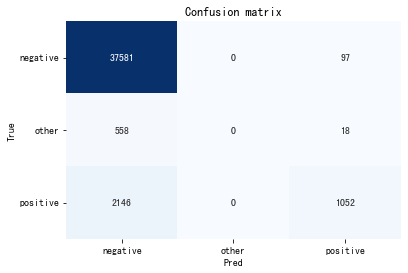

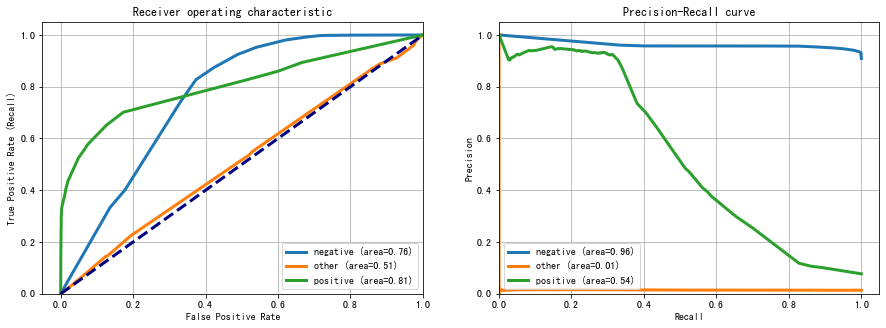

In [190]:
classes = np.unique(y_test_all)
y_test_array = pd.get_dummies(y_test_all, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_all, predicted_all)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_all, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_all, predicted_all))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_all, predicted_all)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_all[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
            label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_all[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

In [191]:
rf_filter = ensemble.RandomForestClassifier()
rf_filter.fit(X_train_filter, y_train_filter)

RandomForestClassifier()

In [192]:
model_type="Random Forest (filered)"
predicted_filter = rf_filter.predict(X_test_filter)
predicted_prob_filter = rf_filter.predict_proba(X_test_filter)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

Accuracy: 0.91
Auc: 0.66
Detail:


C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.91      1.00      0.95     37678
       other       0.00      0.00      0.00       576
    positive       0.59      0.04      0.07      3198

    accuracy                           0.91     41452
   macro avg       0.50      0.34      0.34     41452
weighted avg       0.87      0.91      0.87     41452



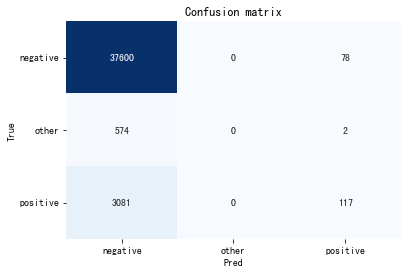

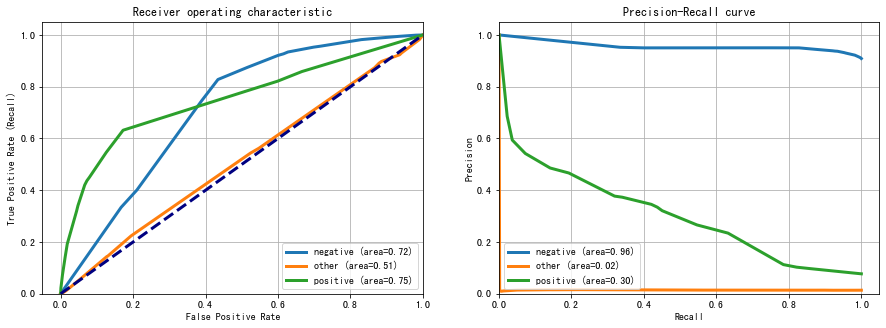

In [193]:
classes = np.unique(y_test_filter)
y_test_array = pd.get_dummies(y_test_filter, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_filter, predicted_filter)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_filter, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_filter, predicted_filter))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_filter, predicted_filter)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_filter[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
            label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_filter[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 2.5. 比較

In [194]:
result_df.sort_values(by=['Accuracy'], ascending=False)

,model_type,Accuracy,AUC
4,Random Forest (all),0.931994,0.694829
2,Decision Tree (all),0.931945,0.694858
0,Logistic Regression (all),0.931559,0.699621
3,Decision Tree (filterd),0.909896,0.659524
5,Random Forest (filered),0.909896,0.659502
1,Logistic Regression (filtered),0.908955,0.662565


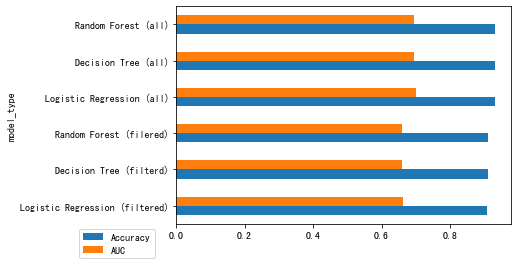

In [195]:
result_df.sort_values(by=['Accuracy'], ascending=True) \
    .plot.barh(x="model_type", y=["Accuracy", "AUC"])
plt.legend(bbox_to_anchor=(-0.05,0))